# Ottimizzazione del Calcolo Scientifico in Python

Come migliorare le performance del codice Python per calcoli intensivi

In [ ]:
# Installiamo le dipendenze necessarie
# !pip install numpy numba scipy cython

## 1. NumPy: La base del calcolo scientifico

NumPy è la libreria fondamentale per il calcolo scientifico in Python. Offre:

- Array multidimensionali efficienti
- Operazioni vettorizzate (senza cicli espliciti)
- Funzioni matematiche ottimizzate
- Interfacce con codice C/C++/Fortran compilato

Il suo grande vantaggio rispetto alle strutture dati native di Python è la velocità.

In [1]:
import numpy as np

NumPy estende Python con gli array e la vettorizzazione delle operazioni, consentendo l'esecuzione parallelizzata su contenitori di dati e molteplici funzionalità per il calcolo scientifico.

### Vettorizzazione vs Cicli

Il punto di forza di NumPy è la vettorizzazione, che permette di operare su interi array senza cicli espliciti.

In [2]:
# Creiamo un array di prova
array = np.random.rand(1000000)

# Approccio con ciclo (lento)
%timeit -n 5 -r 1 result = np.zeros_like(array); [result.__setitem__(i, np.sin(array[i]) + np.cos(array[i])) for i in range(len(array))]

# Approccio vettorizzato (veloce)
%timeit -n 5 -r 1 result = np.sin(array) + np.cos(array)

4.34 s ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
36.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


### I limiti di NumPy

Nonostante le ottimizzazioni, NumPy ha alcune limitazioni:

1. **Global Interpreter Lock (GIL)**: limita il multithreading in Python puro
2. **Overhead di Python**: alcuni algoritmi non possono essere totalmente vettorizzati
3. **Memoria condivisa**: progettato per esecuzione su singola macchina

Per superare questi limiti, possiamo usare altri strumenti.

## 2. Numba: compilazione Just-In-Time

Numba è una libreria che converte codice Python in codice macchina ottimizzato a runtime.

Vantaggi principali:
- **Semplicità**: basta un decoratore `@jit`
- **Prestazioni**: paragonabili a C/C++ per codice numerico
- **Supporto GPU**: esecuzione su NVIDIA CUDA

In [3]:
import numba

### Modalità di compilazione Numba

Numba offre diverse modalità di compilazione:

1. **object mode** (`@jit`): supporta oggetti Python ma con meno ottimizzazioni
2. **nopython mode** (`@njit` o `@jit(nopython=True)`): molto più veloce, ma limitato a tipi semplici
3. **parallel** (`@njit(parallel=True)`): abilita il parallelismo automatico

Per dimostrare l'uso di Numba, useremo l'[insieme di Mandelbrot](https://it.wikipedia.org/wiki/Insieme_di_Mandelbrot), che è uno dei frattali più popolari. La funzione qui sotto visualizza il risultato a partire da un array Numpy.

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_mandelbrot(mandelbrot_array):
    plt.figure(figsize=(10, 6))
    plt.imshow(mandelbrot_array, cmap='hot', extent=[-2, 1, -1.3, 1.3])
    plt.colorbar(label='Iterazioni fino alla divergenza')
    plt.title('Set di Mandelbrot')
    plt.xlabel('Re(c)')
    plt.ylabel('Im(c)')
    plt.tight_layout()
    plt.show()

In [13]:
def mandelbrot_python(h, w, max_iters):
    """Generato da Claude Sonnet."""
    y, x = np.mgrid[-1.3:1.3:h*1j, -2:1:w*1j]
    c = x + y*1j
    z = c
    divtime = np.ones(z.shape, dtype=np.int32) * max_iters

    for i in range(max_iters):
        z = z**2 + c
        diverge = z*np.conj(z) > 2**2
        div_now = diverge & (divtime == max_iters)
        divtime[div_now] = i
        z[diverge] = 2
        
    return divtime

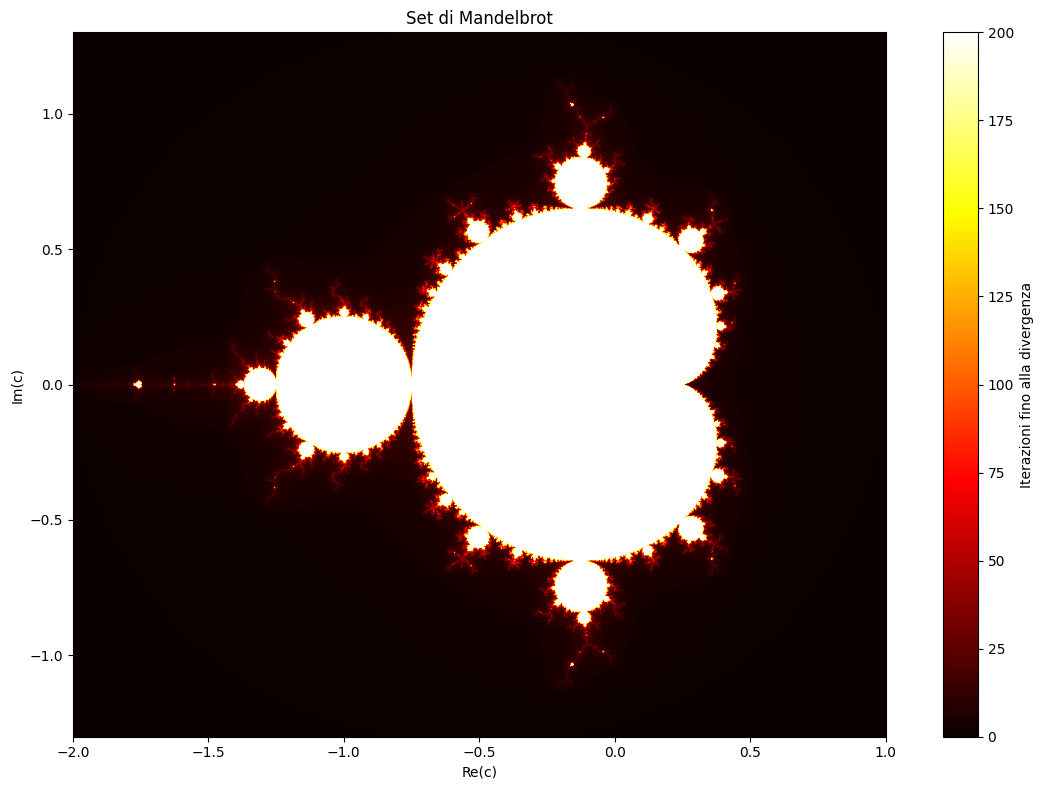

CPU times: total: 12.5 s
Wall time: 14.1 s


In [14]:
%%time
plot_mandelbrot(mandelbrot_python(1000, 1500, 200))

In [15]:
@numba.njit()
def mandelbrot_numba(h, w, max_iters):
    """Generato da Claude Sonnet."""
    result = np.zeros((h, w), dtype=np.int32)
    
    for i in range(h):
        y = -1.3 + (2.6 * i / h)  # mappa i in [-1.3, 1.3]
        for j in range(w):
            x = -2.0 + (3.0 * j / w)  # mappa j in [-2, 1]
            
            # Calcolo del set di Mandelbrot per il punto (x, y)
            c = complex(x, y)
            z = c
            for iter_num in range(max_iters):
                if (z.real*z.real + z.imag*z.imag) > 4.0:
                    result[i, j] = iter_num
                    break
                z = z*z + c
            else:
                result[i, j] = max_iters
    
    return result

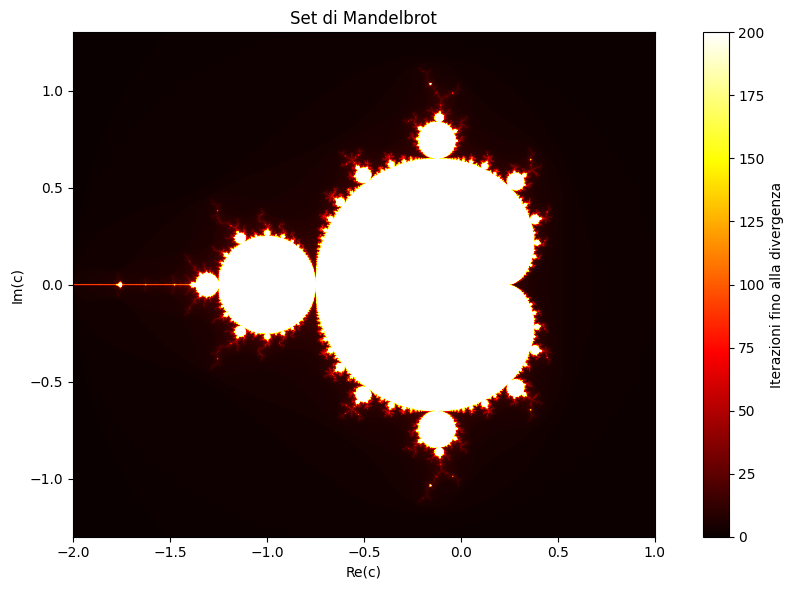

CPU times: total: 969 ms
Wall time: 1.08 s


In [18]:
%%time
plot_mandelbrot(mandelbrot_numba(1000, 1500, 200))

Alla prima esecuzione Numba non riporta performance migliori perché la funzione ha necessità di essere compilata. Rieseguiamo la funzione per notare l'influenza di Numba nell'ottimizzazione.

### Parallelizzazione con Numba

Numba può anche parallelizzare automaticamente il codice usando più core CPU:

In [19]:
@numba.njit(parallel=True)
def mandelbrot_parallel(h, w, max_iters):
    """Generato da Claude Sonnet."""
    result = np.zeros((h, w), dtype=np.int32)
    
    for i in numba.prange(h):
        y = -1.3 + (2.6 * i / h)  # mappa i in [-1.3, 1.3]
        for j in numba.prange(w):
            x = -2.0 + (3.0 * j / w)  # mappa j in [-2, 1]
            
            # Calcolo del set di Mandelbrot per il punto (x, y)
            c = complex(x, y)
            z = c
            for iter_num in numba.prange(max_iters):
                if (z.real*z.real + z.imag*z.imag) > 4.0:
                    result[i, j] = iter_num
                    break
                z = z*z + c
            else:
                result[i, j] = max_iters
    
    return result

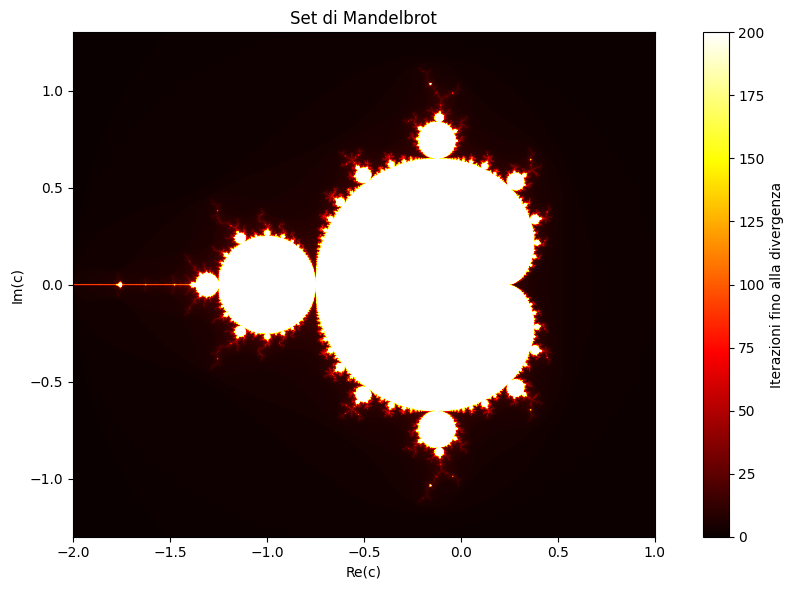

CPU times: total: 2.33 s
Wall time: 2.65 s


In [20]:
%%time
plot_mandelbrot(mandelbrot_parallel(1000, 1500, 200))

### CUDA con Numba

Numba può eseguire codice su GPU NVIDIA tramite il modulo `cuda`. Il vantaggio principale è la parallelizzazione massiva che le GPU offrono, con migliaia di core che possono eseguire calcoli simultaneamente.

In [22]:
from numba import cuda

@cuda.jit
def mandelbrot_kernel(d_result, max_iters, h, w):
    """Kernel CUDA per il calcolo del set di Mandelbrot. Generato da Claude Sonnet"""
    i, j = cuda.grid(2)

    if i < h and j < w:
        x, y = -2.0 + (3.0 * j / w), -1.3 + (2.6 * i / h) 
        z = c = complex(x, y)
        divtime = max_iters
        for k in range(max_iters):
            z_real = z.real
            z_imag = z.imag
            if (z_real*z_real + z_imag*z_imag) > 4.0:
                divtime = k
                break
            z = complex(z_real*z_real - z_imag*z_imag + c.real, 2*z_real*z_imag + c.imag)
        d_result[i, j] = divtime

def mandelbrot_cuda(h, w, max_iters):
    """Calcola il set di Mandelbrot usando CUDA su GPU. Generato da Claude Sonnet"""
    result = np.zeros((h, w), dtype=np.int32)
    d_result = cuda.to_device(result)

    threads_per_block = (16, 16)  # 256 thread per blocco
    blocks_per_grid_x = np.ceil(h / threads_per_block[0]).astype(np.int32)
    blocks_per_grid_y = np.ceil(w / threads_per_block[1]).astype(np.int32)
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    mandelbrot_kernel[blocks_per_grid, threads_per_block](d_result, max_iters, h, w)

    cuda.synchronize()
    return d_result.copy_to_host()

CPU times: total: 0 ns
Wall time: 0 ns


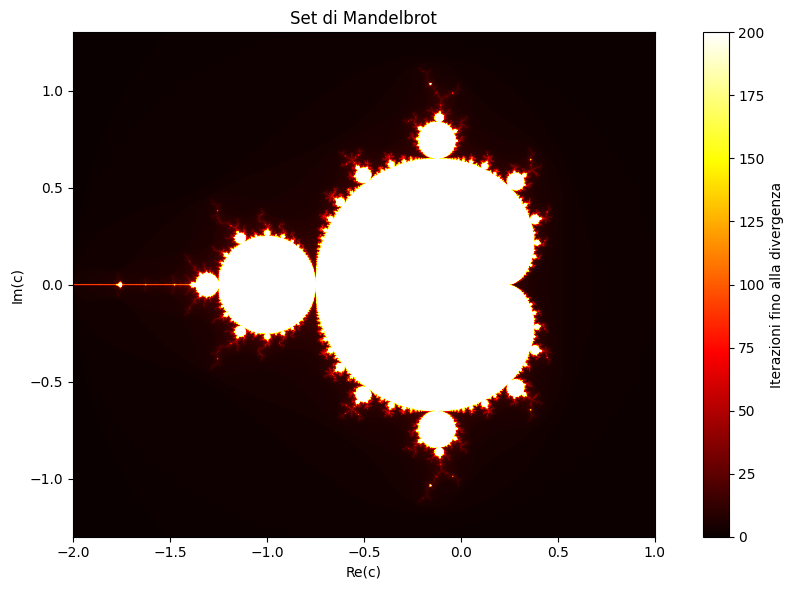

In [23]:
%time
plot_mandelbrot(mandelbrot_cuda(1000, 1500, 200))

## 3. Cython: Un ponte verso C

Cython è un linguaggio che estende Python con tipi statici, permettendo di:

- Evitare il GIL per operazioni intensive
- Usare la sintassi Python con l'efficienza di C
- Creare interfacce con librerie C/C++

In [ ]:
%%file mandelbrot_cy.pyx
# distutils: language=c++
# cython: language_level=3, boundscheck=False, wraparound=False
import numpy as np
cimport numpy as np

def mandelbrot_cython(int h, int w, int max_iters):
    cdef:
        np.ndarray[complex, ndim=2] c = np.zeros((h, w), dtype=complex)
        np.ndarray[complex, ndim=2] z = np.zeros((h, w), dtype=complex)
        np.ndarray[np.int32_t, ndim=2] divtime = np.ones((h, w), dtype=np.int32) * max_iters
        int i, row, col
        double real, imag
        double size_h = 2.6 / h
        double size_w = 3.0 / w
        complex tmp
        bint diverged
    for row in range(h):
        imag = -1.3 + row * size_h
        for col in range(w):
            real = -2.0 + col * size_w
            c[row, col] = real + imag * 1j
            z[row, col] = c[row, col]
    for i in range(max_iters):
        for row in range(h):
            for col in range(w):
                if divtime[row, col] == max_iters:
                    tmp = z[row, col]
                    z[row, col] = tmp * tmp + c[row, col]
                    diverged = (z[row, col].real * z[row, col].real + z[row, col].imag * z[row, col].imag) > 4.0
                    if diverged:
                        divtime[row, col] = i
                        z[row, col] = complex(2.0, 0.0)
    
    return divtime

In [ ]:
%%capture
import pyximport
pyximport.install(setup_args={'include_dirs': np.get_include()}, language_level=3)
import mandelbrot_cy

In [ ]:
%time
plot_mandelbrot(mandelbrot_cy.mandelbrot_cython(1000, 1500, 200))

## 4. Altre librerie per il calcolo scientifico ottimizzato

Oltre a NumPy, Numba e Cython, esistono altre librerie specializzate:

### JAX
JAX combina autograd (derivazione automatica) e XLA (compilazione accelerata) per trasformare codice NumPy in esecuzioni ottimizzate su CPU, GPU e TPU.

### CuPy
CuPy è un'implementazione NumPy-compatibile che esegue il codice direttamente su GPU NVIDIA.